In [2]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

In [3]:
dataset = pd.read_csv('../data/processed/train_86400000000000.csv', parse_dates=[1])
# dataset = dataset.loc[dataset['SiteId'] == 10, :]

In [3]:
dataset.keys()

Index(['ForecastId', 'Timestamp', 'obs_id', 'SiteId', 'Value', 'Frequency',
       'DayOfMonth', 'DayOfWeek', 'DayOfYear', 'DaysInMonth', 'Hour',
       'IsLeapYear', 'IsMonthEnd', 'IsMonthStart', 'IsQuarterEnd',
       'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'Minute', 'Month',
       'Quarter', 'WeekOfYear', 'DayOfMonth_cos', 'DayOfMonth_sin',
       'DayOfWeek_cos', 'DayOfWeek_sin', 'DaysInYear', 'DayOfYear_cos',
       'DayOfYear_sin', 'Hour_cos', 'Hour_sin', 'Minute_cos', 'Minute_sin',
       'Month_cos', 'Month_sin', 'Quarter_cos', 'Quarter_sin',
       'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
       'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations',
       'TemperatureMean', 'TemperatureVariance', 'TemperatureMin',
       'TemperatureMax', 'TemperatureDailyMean', 'TemperatureWeeklyMean',
       'TemperatureMonthlyMean', 'TemperatureQuarterlyMean',
       'TemperatureYearlyMean', 'HasTemperature', 'SamplingRate',
       'BaseTemperatu

In [92]:
from sklearn.preprocessing import scale

dataset['ConsumptionNormalized'] = dataset.groupby('ForecastId')['ConsumptionPerSurfaceArea']\
        .transform(lambda c: scale(c.values)).values
dataset['ConsumptionShift'] = dataset.groupby('ForecastId')['ConsumptionNormalized'].shift(59).values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionShift'].rolling(7*2, min_periods=7).mean().values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionTrend'].transform(lambda x: x.fillna(x[x.first_valid_index()])).values

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [93]:
features = [
    'IsMonthEnd', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'DayOfMonth_cos', 
    'DayOfMonth_sin', 'Quarter_cos', 'Quarter_sin', 'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
    'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations', 'TemperatureMeanDiff', 'TemperatureVariance', 
    'TemperatureMinDiff', 'TemperatureMaxDiff', 'HasTemperature', 'ConsumptionTrend', 'ConsumptionNormalized', 'SiteId',
    'TemperatureDailyMeanDiff', 'TemperatureWeeklyMeanDiff', 'TemperatureMonthlyMeanDiff',
    'TemperatureQuarterlyMeanDiff', 'TemperatureYearlyMeanDiff'
]

ts = pd.get_dummies(dataset[features], columns=['SiteId'])
# ts = dataset[features]

In [94]:
ts_x = ts.drop(columns=['ConsumptionNormalized'])
ts_y = ts['ConsumptionNormalized']
ts_fids = dataset['ForecastId']

ts_fids.value_counts()

982     360
3314    360
5330    360
6149    360
6962    360
5235    360
3312    360
1649    360
1905    360
3396    360
5255    360
1650    360
6726    360
6470    360
3154    360
5233    360
3442    360
4292    360
5238    360
6006    360
4599    360
2804    360
6966    360
3316    360
4294    360
6151    360
3234    360
6004    360
2358    360
407     360
       ... 
878      90
4271     90
6254     90
5230     90
651      90
2807     90
4265     90
6152     90
5256     90
6729     90
1513     90
649      90
2926     90
1391     90
880      90
5234     90
3313     90
3155     90
5232     90
3315     90
1906     90
6256     90
1651     90
2805     90
6967     90
3317     90
5239     90
6007     90
2359     90
6467     90
Name: ForecastId, Length: 224, dtype: int64

In [95]:
import math

input_window_size = 75
output_window_size = 59
frequency = np.timedelta64(1, 'D')

In [96]:
def generate_test_train_split(x, y, forecast_ids, input_window_size, output_window_size, test_size=1):
    min_test_size = (output_window_size) * 2.5
    fids, counts = np.unique(forecast_ids, return_counts=True)
    
    num_forecasts_for_test = round(fids.shape[0]*test_size)
    testable_fids = fids[np.where(counts >= min_test_size)]
    test_fids = testable_fids
#     test_fids = np.random.choice(testable_fids, num_forecasts_for_test)
    
    test_mask = np.repeat([False], forecast_ids.shape[0])
    
    test_size = output_window_size
    for fid in test_fids:
        indices,  = np.where(forecast_ids == fid)
        test_mask[indices[-test_size:]] = True
            
    train_mask = np.logical_not(test_mask)
    
    return x[train_mask], y[train_mask], forecast_ids[train_mask], x[test_mask], y[test_mask], forecast_ids[test_mask]
    
ts_xtrain, ts_ytrain, ts_ftrain, ts_xtest, ts_ytest, ts_ftest = generate_test_train_split(ts_x, ts_y, ts_fids, input_window_size, output_window_size)

print(ts_xtrain.shape, ts_ytrain.shape)
print(ts_xtest.shape, ts_ytest.shape)

(45691, 117) (45691,)
(7139, 117) (7139,)


In [97]:
from xgboost import XGBRegressor

regressor = XGBRegressor(max_depth=90, n_estimators=200, n_jobs=16)
regressor.fit(ts_xtrain, ts_ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=90, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=16, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [98]:
y_pred = regressor.predict(ts_xtest)

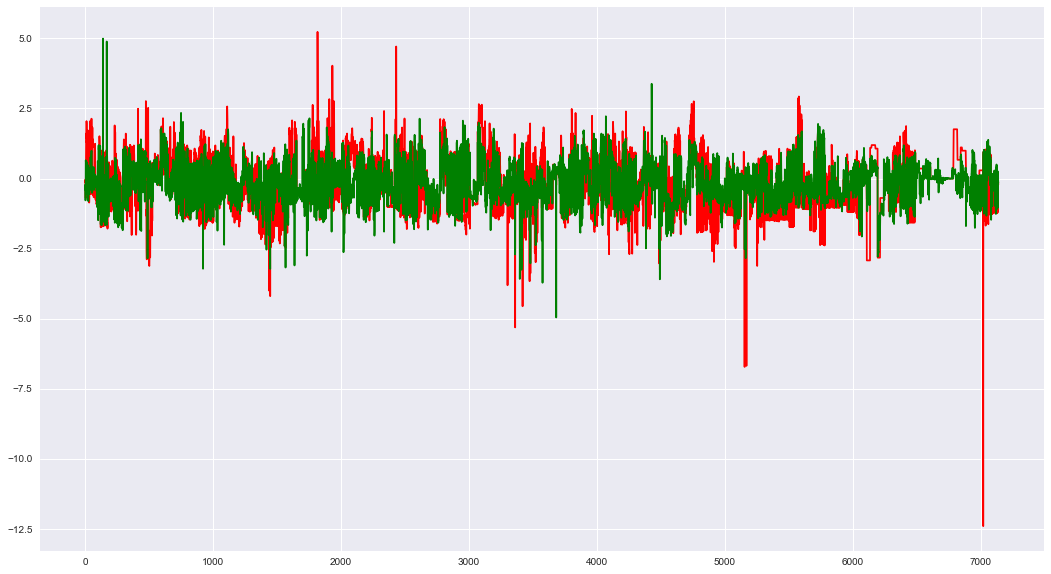

In [99]:
plt.plot(range(ts_ytest.shape[0]), ts_ytest, color='red')
plt.plot(range(ts_ytest.shape[0]), y_pred, color='green')

In [100]:
def _nwrmse(y_truth, y_pred, forecast_ids):
    errors = []

    fids = np.unique(forecast_ids)
    
    for fid in fids:
        forecast_y_pred = y_pred[forecast_ids == fid]
        forecast_y_truth = y_truth[forecast_ids == fid]
        
        count = 200
        weights = (3 * count - 2 * np.arange(1, count + 1) + 1) / (2 * count ** 2)
        weights = weights[:forecast_y_pred.shape[0]]
        
        error = np.sqrt(np.sum(((forecast_y_truth - forecast_y_pred) ** 2) * weights))
        mean_error = error / np.average(forecast_y_truth)
        errors.append(mean_error)

    return np.average(errors)

_nwrmse(ts_ytest, y_pred, ts_ftest)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


inf

In [19]:
y_p = y_pred[-1, :]
print(y_p.shape)
print(ty_test.shape)

plt.plot(np.arange(y_p.shape[0]), ty_test[-1, :].ravel(), color='red')
plt.plot(np.arange(y_p.shape[0]), y_p, color='blue')

IndexError: too many indices for array